In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
from sklearn.decomposition import TruncatedSVD

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering

In [3]:
import re

In [4]:
# from nltk.corpus import stopwords
# stops = set(stopwords.words("english"))

In [316]:
LABEL_COUNT = 20
LABEL_NAMES = ['wordpress', 'oracle', 'svn', 'apache', 'excel', 'matlab', 'visual-studio',
               'cocoa', 'osx', 'bash', 'spring', 'hibernate', 'scala', 'sharepoint', 'ajax',
               'qt', 'drupal', 'linq', 'haskell', 'magento']

In [5]:
CLUSTER_COUNT = 30

In [6]:
n_components = 20
n_features = 10000
verbose = False

In [28]:
METHOD = "lsa_kmeans"
DATA_FOLDER = "data/"
OUTPUT_FOLDER = "output/"
TITLE_FILE = DATA_FOLDER + "title_StackOverflow.txt"
CHECK_INDEX_FILE = DATA_FOLDER + "check_index.csv"
LABEL_FILE = DATA_FOLDER + "label_StackOverflow.txt"

In [8]:
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

In [9]:

# from __future__ import print_function

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

# import logging
# from optparse import OptionParser
# import sys
# from time import time

# import numpy as np


# Read and cleaning data

In [10]:
# # substitute symbols with whitespaces, to lowercase, remove stopwords
# def cleanTitle(title):
#     return ' '.join([w for w in re.sub("[^a-zA-Z]", " ", title).lower().split() if not w in stops])

In [15]:
# substitute symbols with whitespaces, to lowercase
def cleanTitle(title):
    return ' '.join(re.sub("[^a-zA-Z]", " ", title).lower().split())

In [16]:
with open(TITLE_FILE) as f:
    titles = f.read().splitlines()

In [37]:
# read labels and change to 0-based
with open(LABEL_FILE) as file:
    labels = [int(line.strip())-1 for line in file.readlines()]
len(labels)

20000

In [17]:
clean_titles = [cleanTitle(title) for title in titles]

In [18]:
clean_titles[:5]

['how do i fill a dataset or a datatable from a linq query resultset',
 'how do you page a collection with linq',
 'best subversion clients for windows vista bit',
 'best practice collaborative environment bin directory svn',
 'visual studio setup project per user registry settings']

In [36]:
print(len(labels))
print(len(titles))

20000
20000


In [38]:
# concat titles as a big document
concat_titles_by_label = [""] * LABEL_COUNT

for i in range(len(titles)):
    label = labels[i]
    title = titles[i]
    concat_titles_by_label[label] = concat_titles_by_label[label] + cleanTitle(title) + ' '

In [39]:
concat_titles_by_label[1]

'how do i find the high water mark for sessions on oracle i oracle what tns names file am i using oracle sql developer not responsive when trying to view tables or suggest an oracle mac client what content management does your workplace use best way to encapsulate complex oracle pl sql cursor logic as a view resources for an oracle beginner develop on local oracle instance when to commit changes table stats gathering for oracle intergrating perl and oracle aq oracle server performance monitoring tools issue in oracle sql query best way to handle lobs in oracle dblink ed tables microsoft t sql to oracle pl sql translation simulated olap oracle equivalent to mssql datediff pls error on call to cursor how sid is different from service name in oracle tnsnames ora which oracle version supports cube and rollup tools for matching name address data how would you migrate hundreds of ms access databases to a central service is there any good oracle podcasts sql compare like tool for oracle choos

# Find Most Common Words in Clusters

In [ ]:
"""
method 1: each title as a document, calc tfidf, separate titles into 20 cluster, sum the vectors in each cluster
method 2: concatenate same-labeled titles as a document, become 20 documents in total, count tf-idf on them
I use method 2
"""

In [90]:
vectorizer = TfidfVectorizer(analyzer="word", stop_words='english')
doc_vecs = vectorizer.fit_transform(concat_titles_by_label)

In [91]:
doc_vecs.shape

(20, 10269)

In [92]:
words = vectorizer.get_feature_names()

In [93]:
len(words)

10269

In [94]:
# convert sparce matrix to array
doc_vecs_dense = doc_vecs.toarray()

In [95]:
sorted_word_idx = np.argsort(doc_vecs_dense[0])[::-1]
sorted_word_idx

array([10084,  6598, 10122, ...,  6590,  6588,     0])

In [101]:
for i in range(LABEL_COUNT):
    sorted_word_idx = np.argsort(doc_vecs_dense[i])[::-1]
    print(', '.join([words[idx] for idx in sorted_word_idx[:10]]))

wordpress, posts, wp, category, post, blog, page, theme, plugin, php
oracle, sql, pl, ora, table, procedure, query, database, using, stored
svn, subversion, repository, commit, branch, revision, files, file, externals, repositories
apache, mod, rewrite, htaccess, redirect, php, server, rewriterule, url, using
excel, vba, cell, macro, workbook, cells, worksheet, sheet, file, data
matlab, matrix, plot, function, using, array, vector, vectors, image, file
studio, visual, vs, project, solution, build, projects, files, file, code
cocoa, objective, nstableview, nsstring, nsview, core, window, nsoutlineview, app, xcode
mac, os, osx, cocoa, terminal, leopard, application, xcode, app, file
bash, script, file, shell, command, files, line, variable, using, sed
spring, bean, hibernate, beans, mvc, using, security, annotations, annotation, aop
hibernate, hql, mapping, criteria, jpa, query, using, annotations, entity, join
scala, actors, java, lift, type, actor, using, class, list, trait
sharepoint,

# Extract title features

In [104]:
# vectorizer = TfidfVectorizer(analyzer="word", stop_words='english')
# title_vecs = vectorizer.fit_transform(clean_titles)

In [161]:

# Perform an IDF normalization on the output of HashingVectorizer
hasher = HashingVectorizer(n_features=n_features,
                           stop_words='english', non_negative=True,
                           norm=None, binary=False)
vectorizer = make_pipeline(hasher, TfidfTransformer())

X = vectorizer.fit_transform(clean_titles)

svd = TruncatedSVD(n_components)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

# Visualize

In [158]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD, PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [171]:
# dim_reduce = TSNE(n_components=2)
# Y = dim_reduce.fit_transform(X)

In [296]:
# Perform an IDF normalization on the output of HashingVectorizer
# hasher = HashingVectorizer(n_features=n_features,
#                            stop_words='english', non_negative=True,
#                            norm=None, binary=False)
# vectorizer = make_pipeline(hasher, TfidfTransformer())

TfidfVectorizer(analyzer="word", stop_words='english')

X = vectorizer.fit_transform(clean_titles)


svd = TruncatedSVD(n_components=20)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

In [308]:
# svd = TruncatedSVD(n_components=2)
# normalizer = Normalizer(copy=False)
# dim_reducer = make_pipeline(svd, normalizer)

dim_reducer = TSNE(n_components=2)
Y = dim_reducer.fit_transform(X)

In [309]:
Y_clustered = [[] for i in range(LABEL_COUNT)]

for i in range(Y.shape[0]):
    label = labels[i]
    Y_clustered[label].append(Y[i])

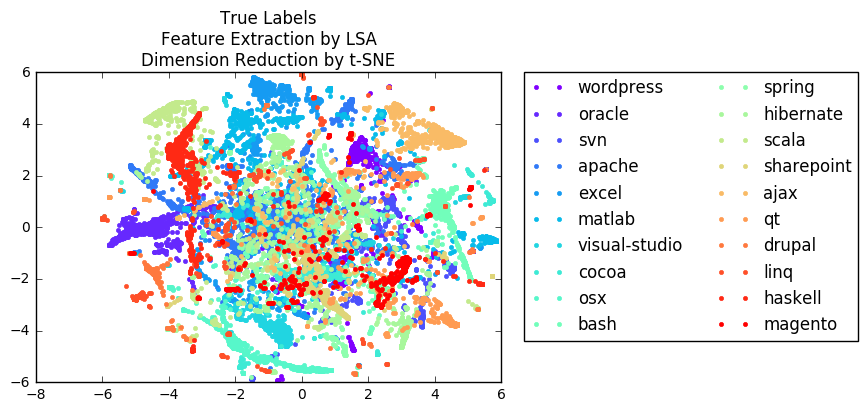

In [334]:
colors = cm.rainbow(np.linspace(0, 1, len(Y_clustered)))

for i in range(len(Y_clustered)):
    _Y = np.array(Y_clustered[i])
    plt.plot(_Y[:,0], _Y[:,1], '.', color=colors[i], label=LABEL_NAMES[i])
plt.title("True Labels\nFeature Extraction by LSA\nDimension Reduction by t-SNE")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=2, borderaxespad=0.)
plt.show()

In [311]:
Y_lsa20_tsne = Y

# Clustering

In [344]:
km = KMeans(n_clusters=80, init='k-means++', max_iter=100, n_init=1,
            verbose=verbose)

km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=80, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)

In [345]:
title_clusters = np.array(km.labels_.tolist())

In [346]:
# from scipy.stats import entropy

# unique, counts = np.unique(title_clusters, return_counts=True)
# print(entropy(counts))
# print(np.asarray((unique, counts)).T)

# Visualize

In [347]:
Y_clustered = [[] for i in range(80)]

for i in range(Y.shape[0]):
    label = title_clusters[i]
    Y_clustered[label].append(Y[i])

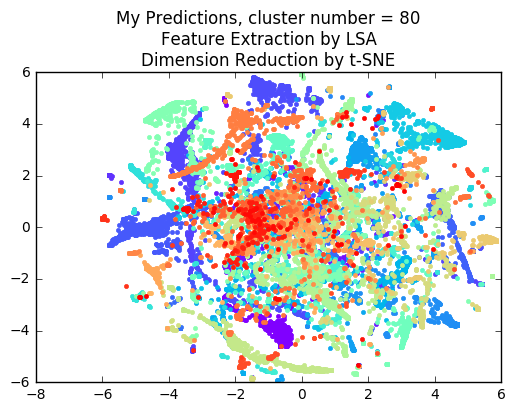

In [349]:
colors = cm.rainbow(np.linspace(0, 1, len(Y_clustered)))

for i in range(len(Y_clustered)):
    _Y = np.array(Y_clustered[i])
    plt.plot(_Y[:,0], _Y[:,1], '.', color=colors[i])
plt.title("My Predictions, cluster number = 80\nFeature Extraction by LSA\nDimension Reduction by t-SNE")
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=2, borderaxespad=0.)
plt.show()

In [55]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD, PCA
import matplotlib.pyplot as plt

In [56]:
pca = PCA(n_components=2)
pca.fit(X)
Y = pca.transform(X)

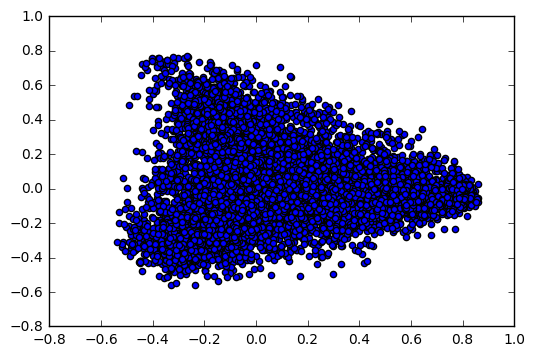

In [57]:
plt.scatter(Y[:,0], Y[:,1])
plt.show()

# output

In [51]:
checkIndexDF = pd.read_csv(CHECK_INDEX_FILE)

In [52]:
checkIndexDF["Ans"] = (title_clusters[checkIndexDF["x_ID"]] == title_clusters[checkIndexDF["y_ID"]]).astype(int)

In [53]:
# checkIndexDF.head(20)

In [54]:
checkIndexDF.to_csv(OUTPUT_FOLDER + METHOD + "_hao_comp20_cluster30_4.csv", columns=["ID", "Ans"], index=False)